In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
from collections import Counter

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

import gensim
from gensim import corpora
import plotly.express as px

###**NLP Preprocessing**

In [2]:
df = pd.read_csv("data_tweet.csv")
df.head()

,LANGUAGE,LOCATION,SENDER,MESSAGE,Impressions,NUMBER_FOLLOWERS,RETWEET_COUNT,Twitter Likes,IS_VERIFIED,HAS_URL,...,IS_QUOTE,IS_RETWEET,DATE,TIME,IS_IN_REPLY_TO,IS_NEWS_AGENCY,TWEET_COUNT,IS_MEDIA,IS_GOVT,IS_PEOPLE
0,en,USA,TurnKyBlue,RT @TristanSnell Get rid of train safety rules...,4414.0,4414.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2023-03-14,21:56:12,NaN,NaN,NaN,0,0,1
1,en,NaN,jrbkjrbk,RT @realTuckFrumper Ohio Sues Norfolk Southern...,1011.0,1011.0,0.0,0.0,0.0,1.0,...,0.0,1.0,2023-03-14,21:56:03,NaN,NaN,NaN,0,0,1
2,en,NaN,camoxendale,RT @SenJeffMerkley We need accountability from...,990.0,990.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2023-03-14,21:55:12,NaN,NaN,NaN,0,0,1
3,en,NaN,strongfemchar,RT @nicksortor 🚨 #BREAKING: The State of Ohio ...,64.0,64.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2023-03-14,21:54:42,NaN,NaN,NaN,0,0,1
4,en,NaN,Waywow,RT @NEWSMAX A new poll finds the majority of A...,2.0,2.0,0.0,0.0,0.0,1.0,...,0.0,1.0,2023-03-14,21:54:29,NaN,NaN,NaN,0,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85220 entries, 0 to 85219
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LANGUAGE          85220 non-null  object 
 1   LOCATION          49974 non-null  object 
 2   SENDER            85220 non-null  object 
 3   MESSAGE           85220 non-null  object 
 4   Impressions       60294 non-null  float64
 5   NUMBER_FOLLOWERS  85220 non-null  float64
 6   RETWEET_COUNT     71853 non-null  float64
 7   Twitter Likes     60294 non-null  float64
 8   IS_VERIFIED       85220 non-null  float64
 9   HAS_URL           85220 non-null  float64
 10  IS_REPLY          85220 non-null  float64
 11  IS_QUOTE          85220 non-null  float64
 12  IS_RETWEET        85220 non-null  float64
 13  DATE              85220 non-null  object 
 14  TIME              85220 non-null  object 
 15  IS_IN_REPLY_TO    24926 non-null  float64
 16  IS_NEWS_AGENCY    24926 non-null  float6

In [4]:
# remove stopwords (not impacting sentiment analysis) and punctuations
stop_words = set(stopwords.words('english')) - set(["no", "not", "nor", "against", "aren't", "couldn't", "didn't", 
                                                   "doesn't", "don't", "haven't", "hadn't", "hasn't", "isn't", "mightn't",
                                             "mustn't", "needn't", "shouldn't", "wasn't", "weren't", "wouldn't"])
# tokenize
tokenizer = RegexpTokenizer(r'\w+')

# lemmatize
lemmatizer = WordNetLemmatizer()

# remove urls
df['Message_no_url'] = df['MESSAGE'].apply(lambda x: " ".join([word for word in x.split(" ") if not(word.startswith("https://"))]))

# tokenize MESSAGE and remove stopwords
df['Text'] = df['Message_no_url'].map(tokenizer.tokenize)
df['Text'] = df['Text'].apply(lambda x : nltk.pos_tag([item.lower() for item in x if item.lower() not in stop_words]))

In [5]:
# lemmatize each token with pos tag
def lemma_token(row):
  
  # pos tag
  def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
  
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), row))
  lemmatized = []
  for word, tag in wordnet_tagged:
    if tag is None:
        # if there is no available tag, just append the original token
        lemmatized.append(word)
    else:       
        # else use the pos tag to lemmatize the token
        lemmatized.append(lemmatizer.lemmatize(word, tag))
  return lemmatized

In [6]:
# apply lemmatization and reset index
df['Text'] = df['Text'].apply(lambda row : lemma_token(row))
df = df.reset_index(drop=True)

# join words
df['T_text'] = df['Text'].apply(lambda row : " ".join(row))

In [7]:
df.head()

,LANGUAGE,LOCATION,SENDER,MESSAGE,Impressions,NUMBER_FOLLOWERS,RETWEET_COUNT,Twitter Likes,IS_VERIFIED,HAS_URL,...,TIME,IS_IN_REPLY_TO,IS_NEWS_AGENCY,TWEET_COUNT,IS_MEDIA,IS_GOVT,IS_PEOPLE,Message_no_url,Text,T_text
0,en,USA,TurnKyBlue,RT @TristanSnell Get rid of train safety rules...,4414.0,4414.0,0.0,0.0,0.0,0.0,...,21:56:12,NaN,NaN,NaN,0,0,1,RT @TristanSnell Get rid of train safety rules...,"[rt, tristansnell, get, rid, train, safety, ru...",rt tristansnell get rid train safety rule get ...
1,en,NaN,jrbkjrbk,RT @realTuckFrumper Ohio Sues Norfolk Southern...,1011.0,1011.0,0.0,0.0,0.0,1.0,...,21:56:03,NaN,NaN,NaN,0,0,1,RT @realTuckFrumper Ohio Sues Norfolk Southern...,"[rt, realtuckfrumper, ohio, sue, norfolk, sout...",rt realtuckfrumper ohio sue norfolk southern t...
2,en,NaN,camoxendale,RT @SenJeffMerkley We need accountability from...,990.0,990.0,0.0,0.0,0.0,0.0,...,21:55:12,NaN,NaN,NaN,0,0,1,RT @SenJeffMerkley We need accountability from...,"[rt, senjeffmerkley, need, accountability, nor...",rt senjeffmerkley need accountability norfolk ...
3,en,NaN,strongfemchar,RT @nicksortor 🚨 #BREAKING: The State of Ohio ...,64.0,64.0,0.0,0.0,0.0,0.0,...,21:54:42,NaN,NaN,NaN,0,0,1,RT @nicksortor 🚨 #BREAKING: The State of Ohio ...,"[rt, nicksortor, break, state, ohio, sue, norf...",rt nicksortor break state ohio sue norfolk sou...
4,en,NaN,Waywow,RT @NEWSMAX A new poll finds the majority of A...,2.0,2.0,0.0,0.0,0.0,1.0,...,21:54:29,NaN,NaN,NaN,0,0,1,RT @NEWSMAX A new poll finds the majority of A...,"[rt, newsmax, new, poll, find, majority, ameri...",rt newsmax new poll find majority american wan...


###**Sentiment Analysis - Word**

In [8]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('averaged_perceptron_tagger')
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 13.3 MB/s eta 0:00:00


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
# perform sentiment analysis using vader
sia = SentimentIntensityAnalyzer()
scores = [sia.polarity_scores(text)['compound'] for text in df['T_text']]

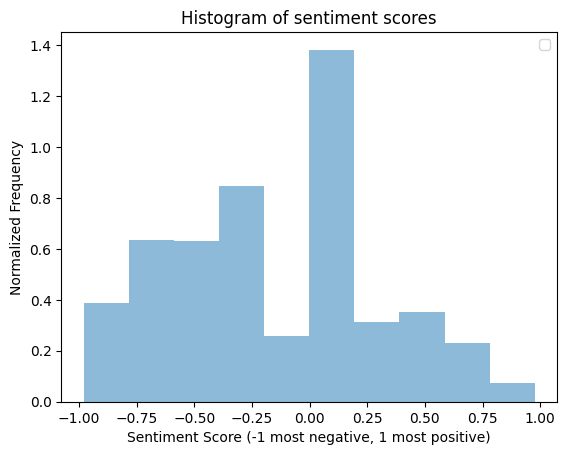

In [12]:
# The histogram of sentiment scores
plt.hist(scores, density = True, alpha = 0.5)
plt.legend(loc='upper right')
plt.xlabel('Sentiment Score (-1 most negative, 1 most positive)')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of sentiment scores')
plt.show()

In [23]:
# create a function to get sentiment
def sentiment_res(sentiment, texts, scores):
  sentiment_result = []
  if sentiment == 'positive':
    for i in range(len(texts)):
      if scores[i] != None and scores[i] > 0.6:
        text_list = df["Text"][i]
        sentiment_result.append(text_list)
  if sentiment == 'negative':
    for i in range(len(texts)):
      if scores[i] != None and scores[i] <= 0.6:
        text_list = df["Text"][i]
        sentiment_result.append(text_list)
  return sentiment_result

In [13]:
negative = sentiment_res('negative', df['T_text'], scores)
positive = sentiment_res('positive', df['T_text'], scores)

In [15]:
# self_defined stopwords
add_stopwords = ['rt','train','southern','east','derailment','norfolk','palestine','february','u','ohio','month','week','news','please']

# count adj, n
def countpos(indices):
  adj_counter = Counter()
  noun_counter = Counter()
  for row in indices:
    for item in nltk.pos_tag(row):
      if item[0] not in add_stopwords:
        if item[1].startswith('J'):
          orig_adj = item[0]
          adj_counter[orig_adj] += 1
        elif item[1].startswith('N'):
          orig_noun = item[0]
          noun_counter[orig_noun] += 1
  return adj_counter, noun_counter

countpos_negative = countpos(negative)
countpos_positive = countpos(positive)

In [52]:
countpos = pd.DataFrame(countpos_negative[0].most_common()[:20]).sort_values(by=[1],ascending=True)
countpos.columns = ["Top Words", "Frequency"]
fig = px.bar(countpos, x="Frequency", y="Top Words", color = "Frequency", template="ggplot2", 
              title = 'Top Negative Adjectives', width=600, height=600)
fig.show()

In [53]:
countpos = pd.DataFrame(countpos_negative[1].most_common()[:20]).sort_values(by=[1],ascending=True)
countpos.columns = ["Top Words", "Frequency"]
fig = px.bar(countpos, x="Frequency", y="Top Words", color = "Frequency", template="ggplot2", 
              title = 'Top Negative Nouns', width=600, height=600)
fig.show()

In [54]:
countpos = pd.DataFrame(countpos_positive[0].most_common()[:20]).sort_values(by=[1],ascending=True)
countpos.columns = ["Top Words", "Frequency"]
fig = px.bar(countpos, x="Frequency", y="Top Words", color = "Frequency", template="ggplot2", 
              title = 'Top Positive Adjectives', width=600, height=600)
fig.show()

In [55]:
countpos = pd.DataFrame(countpos_positive[1].most_common()[:20]).sort_values(by=[1],ascending=True)
countpos.columns = ["Top Words", "Frequency"]
fig = px.bar(countpos, x="Frequency", y="Top Words", color = "Frequency", template="ggplot2", 
              title = 'Top Positive Nouns', width=600, height=600)
fig.show()

##**Sentiment Analysis - Public**

In [21]:
# perform sentiment analysis using vader
sia = SentimentIntensityAnalyzer()
scores_public = [sia.polarity_scores(text)['compound'] for text in df[df["IS_PEOPLE"] == 1]['T_text']]

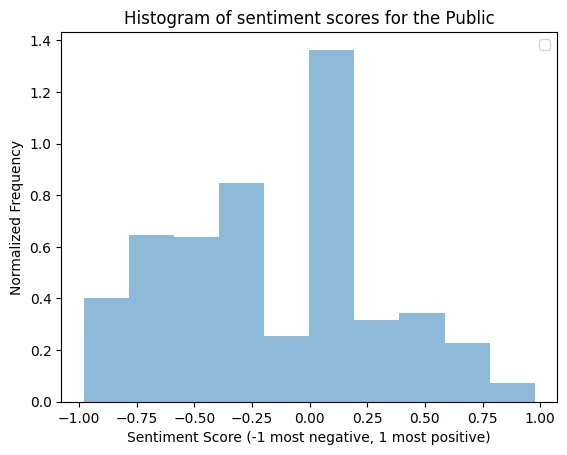

In [22]:
# The histogram of sentiment scores
plt.hist(scores_public, density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Sentiment Score (-1 most negative, 1 most positive)')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of sentiment scores for the Public')
plt.show()

In [24]:
# get tweets divided by threshold
negative_public = sentiment_res('negative', df[df["IS_PEOPLE"] == 1]['T_text'], scores_public)
positive_public = sentiment_res('positive', df[df["IS_PEOPLE"] == 1]['T_text'], scores_public)

# connect words to be text
negative_text_public = [" ".join(row) for row in negative_public]
positive_text_public = [" ".join(row) for row in positive_public]

In [25]:
stop_word_list=stopwords.words('english') + add_stopwords

# Top negative opinions
for i in range(2, 5):
  # text = list of strings
  vectorizer = CountVectorizer(token_pattern = r'\b[a-zA-Z]+\b', lowercase = True, analyzer='word', stop_words = stop_word_list, ngram_range=(i, i))
  x = vectorizer.fit_transform(negative_text_public)

  # we research on top 50
  wordcount = dict(pd.DataFrame(x.toarray(), columns = vectorizer.get_feature_names_out()).sum(axis=0))
  print(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:50])

  # display top 30 for better visualization
  sorted_wordcount = pd.DataFrame(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:30]).sort_values(by=[1],ascending=True)
  sorted_wordcount.columns = ["Top Phrases", "Frequency"]
  fig = px.bar(sorted_wordcount, x="Frequency", y="Top Phrases", color = "Frequency", template="ggplot2", 
               title = 'Top negative opinions from the Public', width=600, height=600)
  fig.show()

[('toxic chemical', 2564), ('hazardous material', 2069), ('pete buttigieg', 1670), ('vinyl chloride', 1285), ('another derails', 1146), ('derails alabama', 1109), ('carry hazardous', 954), ('alan shaw', 874), ('ceo testifies', 844), ('chemical spill', 815), ('ceo alan', 807), ('donald trump', 799), ('biden administration', 759), ('official say', 733), ('safety rule', 727), ('hazardous chemical', 714), ('another derail', 709), ('safety regulation', 698), ('shelter place', 697), ('town hall', 684), ('alabama hour', 678), ('mike dewine', 652), ('transportation secretary', 649), ('rail worker', 626), ('dump truck', 608), ('epa order', 602), ('car derail', 590), ('toxic wreck', 590), ('trump visit', 582), ('roll back', 574), ('rail safety', 560), ('north carolina', 556), ('hour ceo', 555), ('safety board', 550), ('carry toxic', 549), ('secretary pete', 536), ('chemical derail', 520), ('high hazard', 507), ('testifies congress', 501), ('transportation safety', 495), ('calhoun county', 477), 

[('ceo alan shaw', 755), ('carry hazardous material', 612), ('derails alabama hour', 512), ('secretary pete buttigieg', 499), ('ceo testifies congress', 497), ('alabama hour ceo', 488), ('carry toxic chemical', 468), ('transportation safety board', 459), ('gov mike dewine', 452), ('national transportation safety', 448), ('transportation secretary pete', 446), ('hour ceo testifies', 441), ('derails north carolina', 382), ('car cargo derail', 371), ('calhoun county alabama', 360), ('environmental protection agency', 348), ('release toxic chemical', 316), ('toxic chemical derail', 306), ('north carolina danger', 283), ('carry hazardous chemical', 279), ('derails alabama ceo', 256), ('alabama ceo testifies', 244), ('epa order clean', 240), ('tell shelter place', 233), ('danger public report', 232), ('trump roll back', 232), ('high hazard flammable', 231), ('carolina danger public', 230), ('worker tell skip', 229), ('rail worker tell', 227), ('tell skip inspection', 227), ('us rail worker',

[('derails alabama hour ceo', 448), ('national transportation safety board', 443), ('transportation secretary pete buttigieg', 436), ('alabama hour ceo testifies', 432), ('hour ceo testifies congress', 420), ('derails north carolina danger', 283), ('carry toxic chemical derail', 245), ('derails alabama ceo testifies', 240), ('carolina danger public report', 230), ('north carolina danger public', 230), ('rail worker tell skip', 227), ('worker tell skip inspection', 226), ('us rail worker tell', 224), ('resident tell shelter place', 209), ('launch myid emergency service', 206), ('audio reveals us rail', 204), ('myid emergency service surveil', 203), ('reveals us rail worker', 203), ('emergency service surveil biometrics', 199), ('derail calhoun county alabama', 196), ('tell skip inspection crash', 196), ('local farmer sound alarm', 194), ('farmer sound alarm launch', 192), ('leak audio reveals us', 192), ('trump delivers truckloads water', 192), ('alarm launch myid emergency', 190), ('so

In [26]:
# Top positive opinions
for i in range(2, 5):
  # text = list of strings
  vectorizer = CountVectorizer(token_pattern = r'\b[a-zA-Z]+\b', lowercase = True, analyzer='word', stop_words = stop_word_list, ngram_range=(i, i))
  x = vectorizer.fit_transform(positive_text_public)

  wordcount = dict(pd.DataFrame(x.toarray(), columns = vectorizer.get_feature_names_out()).sum(axis=0))
  print(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:50])

  sorted_wordcount = pd.DataFrame(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:30]).sort_values(by=[1],ascending=True)
  sorted_wordcount.columns = ["Top Phrases", "Frequency"]
  fig = px.bar(sorted_wordcount, x="Frequency", y="Top Phrases", color = "Frequency", template="ggplot2", 
               title = 'Top positive opinions from the Public', width=600, height=600)
  fig.show()

[('toxic chemical', 167), ('hazardous material', 116), ('pete buttigieg', 111), ('vinyl chloride', 61), ('transportation secretary', 59), ('safety rule', 56), ('another derails', 54), ('chemical spill', 52), ('epa order', 52), ('derails alabama', 50), ('carry hazardous', 49), ('biden administration', 48), ('donald trump', 47), ('hazardous chemical', 45), ('trump visit', 45), ('alan shaw', 44), ('safety regulation', 44), ('town hall', 44), ('secretary pete', 43), ('blame trump', 41), ('high hazard', 40), ('ceo alan', 38), ('official say', 38), ('rail worker', 38), ('roll back', 38), ('ceo testifies', 37), ('mike dewine', 36), ('rail safety', 35), ('carry toxic', 34), ('another derail', 33), ('dump truck', 33), ('chemical derail', 32), ('hold accountable', 31), ('rail company', 31), ('toxic wreck', 31), ('trump administration', 29), ('air water', 28), ('order clean', 28), ('release toxic', 28), ('shelter place', 28), ('brake rule', 27), ('chemical release', 27), ('environmental protectio

[('secretary pete buttigieg', 41), ('transportation secretary pete', 38), ('ceo alan shaw', 37), ('carry hazardous material', 32), ('carry toxic chemical', 30), ('epa order clean', 25), ('environmental protection agency', 24), ('gov mike dewine', 23), ('national transportation safety', 23), ('transportation safety board', 23), ('release toxic chemical', 22), ('calhoun county alabama', 20), ('high hazard cargo', 20), ('spill toxic chemical', 20), ('alabama hour ceo', 19), ('gov josh shapiro', 19), ('categorize high hazard', 18), ('trump roll back', 18), ('car cargo derail', 17), ('ceo testifies congress', 17), ('derails alabama hour', 17), ('derail calhoun county', 16), ('hour ceo testifies', 16), ('toxic chemical derail', 16), ('derail categorize high', 15), ('derails north carolina', 15), ('pete buttigieg visit', 15), ('president donald trump', 15), ('us rail worker', 15), ('alarm launch myid', 14), ('audio reveals us', 14), ('dump truck cleveland', 14), ('effect would apply', 14), ('

[('transportation secretary pete buttigieg', 37), ('national transportation safety board', 22), ('categorize high hazard cargo', 17), ('derails alabama hour ceo', 17), ('alabama hour ceo testifies', 16), ('derail calhoun county alabama', 15), ('derail categorize high hazard', 15), ('alarm launch myid emergency', 14), ('audio reveals us rail', 14), ('emergency service surveil biometrics', 14), ('farmer sound alarm launch', 14), ('hour ceo testifies congress', 14), ('launch myid emergency service', 14), ('leak audio reveals us', 14), ('local farmer sound alarm', 14), ('myid emergency service surveil', 14), ('rail worker tell skip', 14), ('reveals us rail worker', 14), ('sound alarm launch myid', 14), ('tell skip inspection crash', 14), ('us rail worker tell', 14), ('worker tell skip inspection', 14), ('former president donald trump', 13), ('apply derail categorize high', 12), ('carry toxic chemical derail', 12), ('crash prompt scrutiny industry', 12), ('derails alabama ceo testifies', 12

##**Sentiment Analysis - Media**

In [27]:
# perform sentiment analysis using vader
sia = SentimentIntensityAnalyzer()
scores_media = [sia.polarity_scores(text)['compound'] for text in df[df["IS_MEDIA"] == 1]['T_text']]

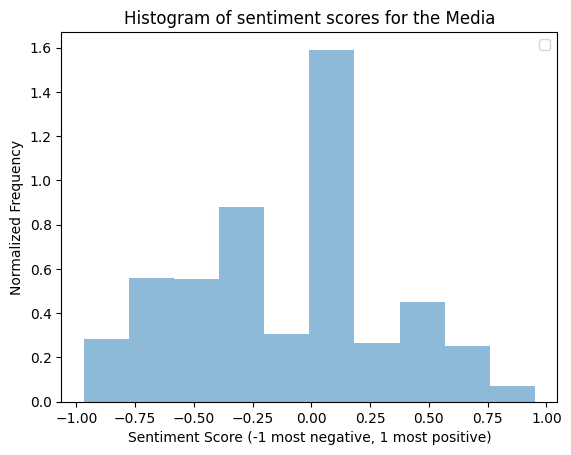

In [28]:
# The histogram of sentiment scores
plt.hist(scores_media, density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Sentiment Score (-1 most negative, 1 most positive)')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of sentiment scores for the Media')
plt.show()

In [29]:
# get tweets divided by threshold
negative_media = sentiment_res('negative', df[df["IS_MEDIA"] == 1]['T_text'], scores_media)
positive_media = sentiment_res('positive', df[df["IS_MEDIA"] == 1]['T_text'], scores_media)

# connect words to be text
negative_text_media = [" ".join(row) for row in negative_media]
positive_text_media = [" ".join(row) for row in positive_media]

In [30]:
stop_word_list=stopwords.words('english') + add_stopwords

# Top negative opinions
for i in range(2, 5):
  # text = list of strings
  vectorizer = CountVectorizer(token_pattern = r'\b[a-zA-Z]+\b', lowercase = True, analyzer='word', stop_words = stop_word_list, ngram_range=(i, i))
  x = vectorizer.fit_transform(negative_text_media)

  wordcount = dict(pd.DataFrame(x.toarray(), columns = vectorizer.get_feature_names_out()).sum(axis=0))
  print(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:50])

  sorted_wordcount = pd.DataFrame(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:30]).sort_values(by=[1],ascending=True)
  sorted_wordcount.columns = ["Top Phrases", "Frequency"]
  fig = px.bar(sorted_wordcount, x="Frequency", y="Top Phrases", color = "Frequency", template="ggplot2", 
               title = 'Top negative opinions from the Media', width=600, height=600)
  fig.show()
  '''
  pd.DataFrame(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:50]).sort_values(by=[1],ascending=True).plot.barh(
             x=0,y=1,figsize=(8,8),title='Top negative opinions from the Media',
             xlabel='Top Phrase',ylabel='Frequency',legend=False)'''

[('derails alabama', 322), ('alan shaw', 264), ('ceo alan', 244), ('ceo testifies', 236), ('alabama hour', 201), ('dump truck', 182), ('toxic chemical', 175), ('hour ceo', 170), ('hazardous material', 166), ('calhoun county', 163), ('another derails', 159), ('testifies congress', 144), ('senate hearing', 133), ('county alabama', 129), ('deeply sorry', 124), ('ceo testify', 119), ('another derail', 116), ('rail safety', 107), ('testify congress', 100), ('ceo apologize', 99), ('sue toxic', 90), ('safety regulation', 81), ('safety board', 80), ('senate committee', 80), ('derail calhoun', 78), ('alabama ceo', 77), ('chemical spill', 75), ('loose wheel', 74), ('million dollar', 74), ('attorney general', 73), ('make right', 69), ('vinyl chloride', 69), ('carry hazardous', 68), ('roll back', 66), ('derail alabama', 65), ('employee kill', 65), ('pay million', 65), ('pennsylvania border', 65), ('watch live', 64), ('yet another', 64), ('car derail', 63), ('truck cleveland', 63), ('pete buttigieg

[('ceo alan shaw', 240), ('alabama hour ceo', 145), ('ceo testifies congress', 143), ('derails alabama hour', 142), ('hour ceo testifies', 130), ('calhoun county alabama', 129), ('derail calhoun county', 75), ('ceo testify congress', 71), ('derails alabama ceo', 69), ('alabama ceo testifies', 63), ('dump truck cleveland', 63), ('transportation safety board', 53), ('another derails ceo', 50), ('carry hazardous material', 49), ('national transportation safety', 49), ('deeply sorry impact', 47), ('alan shaw testify', 46), ('fiery pennsylvania border', 46), ('crash dump truck', 45), ('collides dump truck', 44), ('say deeply sorry', 42), ('break derail calhoun', 39), ('ceo apologize congress', 39), ('derails ceo testify', 39), ('hour company ceo', 38), ('testifies congress via', 38), ('firm test air', 37), ('congress via nbcnews', 36), ('hire firm test', 36), ('test air home', 36), ('watch live ceo', 36), ('air home expert', 35), ('expert warn check', 35), ('home expert warn', 35), ('millio

[('derails alabama hour ceo', 131), ('alabama hour ceo testifies', 129), ('hour ceo testifies congress', 126), ('derail calhoun county alabama', 72), ('derails alabama ceo testifies', 63), ('national transportation safety board', 49), ('ceo alan shaw testify', 45), ('ceo testifies congress via', 38), ('derails ceo testify congress', 38), ('break derail calhoun county', 37), ('another derails ceo testify', 36), ('firm test air home', 36), ('hire firm test air', 36), ('testifies congress via nbcnews', 36), ('air home expert warn', 35), ('expert warn check lack', 35), ('home expert warn check', 35), ('pledge million dollar help', 35), ('test air home expert', 35), ('million dollar help recover', 33), ('amendment advocate state economy', 32), ('get late win second', 32), ('late win second amendment', 32), ('second amendment advocate state', 32), ('win second amendment advocate', 32), ('alabama hour company ceo', 31), ('crash dump truck cleveland', 31), ('dump truck cleveland employee', 31)

In [31]:
# Top positive opinions
for i in range(2, 5):
  # text = list of strings
  vectorizer = CountVectorizer(token_pattern = r'\b[a-zA-Z]+\b', lowercase = True, analyzer='word', stop_words = stop_word_list, ngram_range=(i, i))
  x = vectorizer.fit_transform(positive_text_media)

  wordcount = dict(pd.DataFrame(x.toarray(), columns = vectorizer.get_feature_names_out()).sum(axis=0))
  print(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:50])

  sorted_wordcount = pd.DataFrame(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:30]).sort_values(by=[1],ascending=True)
  sorted_wordcount.columns = ["Top Phrases", "Frequency"]
  fig = px.bar(sorted_wordcount, x="Frequency", y="Top Phrases", color = "Frequency", template="ggplot2", 
               title = 'Top positive opinions from the Media', width=600, height=600)
  fig.show()

[('dump truck', 15), ('toxic chemical', 14), ('derails alabama', 12), ('rail safety', 12), ('another derails', 10), ('ceo testifies', 10), ('deeply sorry', 9), ('alabama hour', 8), ('alan shaw', 8), ('ceo alan', 8), ('chemical spill', 8), ('calhoun county', 7), ('senate hearing', 7), ('sue toxic', 7), ('testifies congress', 7), ('vinyl chloride', 7), ('would want', 7), ('ceo apologize', 6), ('ceo tell', 6), ('collides dump', 6), ('hazardous chemical', 6), ('health concern', 6), ('hour ceo', 6), ('yet another', 6), ('alabama ceo', 5), ('another derail', 5), ('concern mount', 5), ('congress deeply', 5), ('county alabama', 5), ('employee kill', 5), ('environmental damage', 5), ('hazardous material', 5), ('kill collides', 5), ('million dollar', 5), ('pete buttigieg', 5), ('public health', 5), ('social security', 5), ('yost say', 5), ('answer question', 4), ('attorney general', 4), ('carry hazardous', 4), ('carry toxic', 4), ('ceo testify', 4), ('ceo testimony', 4), ('chemical release', 4),

[('ceo alan shaw', 8), ('ceo testifies congress', 7), ('collides dump truck', 6), ('alabama ceo testifies', 5), ('alabama hour ceo', 5), ('calhoun county alabama', 5), ('congress deeply sorry', 5), ('derails alabama ceo', 5), ('derails alabama hour', 5), ('health concern mount', 5), ('hour ceo testifies', 5), ('kill collides dump', 5), ('carry toxic chemical', 4), ('ceo tell congress', 4), ('tell congress deeply', 4), ('toxic chemical spill', 4), ('worker kill collides', 4), ('would want live', 4), ('alabama hour company', 3), ('alan shaw face', 3), ('another derails time', 3), ('balk compensate homeowner', 3), ('bipartisan rail safety', 3), ('buy house say', 3), ('car jaw drop', 3), ('ceo apologize congress', 3), ('check position move', 3), ('cleanup environmental damage', 3), ('company ceo alan', 3), ('compensate homeowner whose', 3), ('conductor dead yet', 3), ('cover cost response', 3), ('dave yost say', 3), ('dead yet another', 3), ('dollar help recover', 3), ('dump truck report',

[('alabama hour ceo testifies', 5), ('derails alabama ceo testifies', 5), ('derails alabama hour ceo', 5), ('hour ceo testifies congress', 5), ('kill collides dump truck', 5), ('ceo tell congress deeply', 4), ('tell congress deeply sorry', 4), ('worker kill collides dump', 4), ('alabama hour company ceo', 3), ('alan shaw face lawmaker', 3), ('balk compensate homeowner whose', 3), ('buy house say would', 3), ('ceo alan shaw face', 3), ('check position move feel', 3), ('cleanup environmental damage cause', 3), ('collides dump truck report', 3), ('company ceo alan shaw', 3), ('compensate homeowner whose home', 3), ('conductor dead yet another', 3), ('dead yet another incident', 3), ('face lawmaker answer question', 3), ('feel trap would want', 3), ('homeowner whose home value', 3), ('hour company ceo alan', 3), ('house say would want', 3), ('lead toxic chemical spill', 3), ('million dollar help recover', 3), ('move feel trap would', 3), ('pay cleanup environmental damage', 3), ('pledge mi

##**Sentiment Analysis - Government**

In [32]:
# perform sentiment analysis using vader
sia = SentimentIntensityAnalyzer()
scores_gov = [sia.polarity_scores(text)['compound'] for text in df[df["IS_GOVT"] == 1]['T_text']]

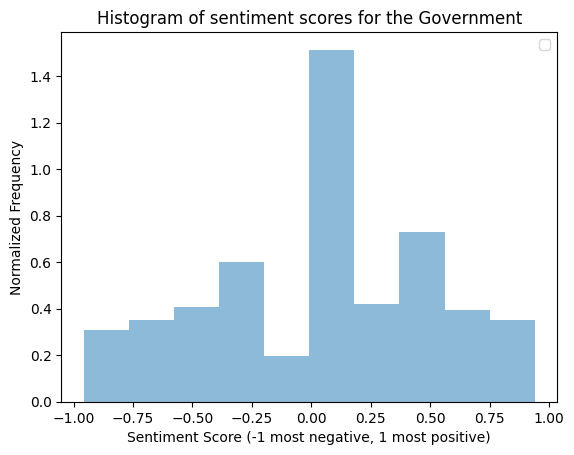

In [33]:
# The histogram of sentiment scores
plt.hist(scores_gov, density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Sentiment Score (-1 most negative, 1 most positive)')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of sentiment scores for the Government')
plt.show()

In [34]:
# get tweets divided by threshold
negative_gov = sentiment_res('negative', df[df["IS_GOVT"] == 1]['T_text'], scores_gov)
positive_gov = sentiment_res('positive', df[df["IS_GOVT"] == 1]['T_text'], scores_gov)

# connect word to text
negative_text_gov = [" ".join(row) for row in negative_gov]
positive_text_gov = [" ".join(row) for row in positive_gov]

In [35]:
stop_word_list=stopwords.words('english') + add_stopwords

# Top negative opinions
for i in range(2, 5):
  # text = list of strings
  vectorizer = CountVectorizer(token_pattern = r'\b[a-zA-Z]+\b', lowercase = True, analyzer='word', stop_words = stop_word_list, ngram_range=(i, i))
  x = vectorizer.fit_transform(negative_text_gov)

  wordcount = dict(pd.DataFrame(x.toarray(), columns = vectorizer.get_feature_names_out()).sum(axis=0))
  print(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:50])

  sorted_wordcount = pd.DataFrame(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:30]).sort_values(by=[1],ascending=True)
  sorted_wordcount.columns = ["Top Phrases", "Frequency"]
  fig = px.bar(sorted_wordcount, x="Frequency", y="Top Phrases", color = "Frequency", template="ggplot2", 
               title = 'Top negative opinions from the Government', width=600, height=600)
  fig.show()

[('sue toxic', 76), ('attorney general', 52), ('file lawsuit', 25), ('environmental damage', 24), ('make sure', 21), ('pay cleanup', 21), ('cleanup environmental', 20), ('lawsuit railroad', 20), ('railroad make', 20), ('sure pay', 20), ('damage cause', 19), ('federal lawsuit', 19), ('dave yost', 17), ('general sue', 17), ('cause fiery', 16), ('file federal', 15), ('state attorney', 14), ('general say', 13), ('entirely avoidable', 12), ('state sue', 12), ('border last', 11), ('fiery pennsylvania', 11), ('pennsylvania border', 11), ('general dave', 10), ('toxic chemical', 10), ('last state', 8), ('pay environmental', 8), ('cleanup economic', 7), ('company pay', 7), ('economic damage', 7), ('environmental cleanup', 7), ('hazardous material', 7), ('railroad pay', 7), ('sue entirely', 7), ('sue seek', 7), ('sue smartnews', 7), ('sue via', 7), ('ag sue', 6), ('carry hazardous', 6), ('force company', 6), ('monitoring year', 6), ('say tuesday', 6), ('sue feb', 6), ('via nbcnews', 6), ('year co

[('cleanup environmental damage', 20), ('file lawsuit railroad', 20), ('make sure pay', 20), ('pay cleanup environmental', 20), ('railroad make sure', 20), ('sure pay cleanup', 20), ('environmental damage cause', 19), ('lawsuit railroad make', 19), ('attorney general sue', 17), ('damage cause fiery', 16), ('file federal lawsuit', 15), ('state attorney general', 14), ('attorney general say', 13), ('cause fiery pennsylvania', 11), ('fiery pennsylvania border', 11), ('pennsylvania border last', 11), ('attorney general dave', 10), ('general dave yost', 10), ('last state attorney', 8), ('cleanup economic damage', 7), ('environmental cleanup economic', 7), ('pay environmental cleanup', 7), ('railroad pay environmental', 7), ('sue entirely avoidable', 7), ('border last state', 6), ('force company pay', 6), ('general say tuesday', 6), ('general sue smartnews', 6), ('aim make railroad', 5), ('attorney general announces', 5), ('carry hazardous material', 5), ('dave yost announce', 5), ('economic

[('make sure pay cleanup', 20), ('pay cleanup environmental damage', 20), ('cleanup environmental damage cause', 19), ('file lawsuit railroad make', 19), ('lawsuit railroad make sure', 19), ('railroad make sure pay', 19), ('sure pay cleanup environmental', 19), ('environmental damage cause fiery', 16), ('state attorney general say', 13), ('cause fiery pennsylvania border', 11), ('damage cause fiery pennsylvania', 11), ('fiery pennsylvania border last', 11), ('attorney general dave yost', 10), ('last state attorney general', 8), ('environmental cleanup economic damage', 7), ('pay environmental cleanup economic', 7), ('railroad pay environmental cleanup', 7), ('attorney general say tuesday', 6), ('attorney general sue smartnews', 6), ('border last state attorney', 6), ('pennsylvania border last state', 6), ('aim make railroad pay', 5), ('attorney general announces lawsuit', 5), ('attorney general sue allege', 5), ('economic loss village surround', 5), ('federal lawsuit state attorney', 5

In [36]:
# Top positive opinions
for i in range(2, 5):
  # text = list of strings
  vectorizer = CountVectorizer(token_pattern = r'\b[a-zA-Z]+\b', lowercase = True, analyzer='word', stop_words = stop_word_list, ngram_range=(i, i))
  x = vectorizer.fit_transform(positive_text_gov)

  wordcount = dict(pd.DataFrame(x.toarray(), columns = vectorizer.get_feature_names_out()).sum(axis=0))
  print(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:50])

  sorted_wordcount = pd.DataFrame(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:30]).sort_values(by=[1],ascending=True)
  sorted_wordcount.columns = ["Top Phrases", "Frequency"]
  fig = px.bar(sorted_wordcount, x="Frequency", y="Top Phrases", color = "Frequency", template="ggplot2", 
               title = 'Top positive opinions from the Government', width=600, height=600)
  fig.show()

[('sue toxic', 16), ('attorney general', 6), ('federal lawsuit', 5), ('file federal', 5), ('economic damage', 4), ('pay environmental', 4), ('aim make', 3), ('cleanup economic', 3), ('company pay', 3), ('dave yost', 3), ('environmental cleanup', 3), ('make railroad', 3), ('railroad pay', 3), ('sue aim', 3), ('ap sue', 2), ('break sue', 2), ('civil lawsuit', 2), ('civil penalty', 2), ('columbus ap', 2), ('count civil', 2), ('damage cause', 2), ('federal court', 2), ('file count', 2), ('gallon hazardous', 2), ('general dave', 2), ('general say', 2), ('get rid', 2), ('hazardous material', 2), ('hold financially', 2), ('lawsuit federal', 2), ('lawsuit state', 2), ('make sure', 2), ('million gallon', 2), ('pay cleanup', 2), ('president trump', 2), ('rule get', 2), ('safety rule', 2), ('seek civil', 2), ('silicon valley', 2), ('state attorney', 2), ('valley bank', 2), ('year come', 2), ('yost announce', 2), ('accountable governorshapiro', 1), ('accuse railroad', 1), ('actbrigitte immediately

[('file federal lawsuit', 5), ('aim make railroad', 3), ('cleanup economic damage', 3), ('environmental cleanup economic', 3), ('make railroad pay', 3), ('pay environmental cleanup', 3), ('railroad pay environmental', 3), ('sue aim make', 3), ('ap sue aim', 2), ('attorney general dave', 2), ('attorney general say', 2), ('civil lawsuit federal', 2), ('columbus ap sue', 2), ('count civil lawsuit', 2), ('dave yost announce', 2), ('federal lawsuit state', 2), ('file count civil', 2), ('general dave yost', 2), ('lawsuit federal court', 2), ('lawsuit state attorney', 2), ('million gallon hazardous', 2), ('safety rule get', 2), ('seek civil penalty', 2), ('silicon valley bank', 2), ('state attorney general', 2), ('accountable governorshapiro impact', 1), ('accuse railroad violate', 1), ('actbrigitte immediately crashed', 1), ('actforamerica zeteamd djtisright', 1), ('admits trump dismantle', 1), ('ag office sue', 1), ('ag sue toxic', 1), ('ag yost file', 1), ('ago biden yet', 1), ('aim suit m

[('aim make railroad pay', 3), ('environmental cleanup economic damage', 3), ('make railroad pay environmental', 3), ('pay environmental cleanup economic', 3), ('railroad pay environmental cleanup', 3), ('sue aim make railroad', 3), ('ap sue aim make', 2), ('attorney general dave yost', 2), ('civil lawsuit federal court', 2), ('columbus ap sue aim', 2), ('count civil lawsuit federal', 2), ('federal lawsuit state attorney', 2), ('file count civil lawsuit', 2), ('file federal lawsuit state', 2), ('general dave yost announce', 2), ('lawsuit state attorney general', 2), ('state attorney general say', 2), ('accountable governorshapiro impact pennsylvania', 1), ('accuse railroad violate numerous', 1), ('actbrigitte immediately crashed democrat', 1), ('actforamerica zeteamd djtisright sue', 1), ('admits trump dismantle regulation', 1), ('ag office sue toxic', 1), ('ag sue toxic chemical', 1), ('ag yost file count', 1), ('ago biden yet visit', 1), ('aim suit make company', 1), ('air stream riv